In [1]:
import math
import torch
import numpy as np
import pandas as pd
import gpytorch
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
import sys
import os

py_file_location = '../utils'
sys.path.append(os.path.abspath(py_file_location))
py_file_location = '../models'
sys.path.append(os.path.abspath(py_file_location))

import count_utils
import classification_utils
import count_models

In [3]:
seed = 5 #1,2,3,4,5
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
import datetime
def datetime_to_str(timestamp):

    date_time = datetime.datetime.fromtimestamp(timestamp)
    s = date_time.strftime("%Y/%d/%m")
    return(s)

def str_to_datetime(s):
    element = datetime.datetime.strptime(s, "%Y/%d/%m")
    timestamp = datetime.datetime.timestamp(element)
    return(timestamp)

print(str_to_datetime("2007/24/05"))
print(datetime_to_str(1179957600.0))

1179957600.0
2007/24/05


# Load data

you can find an explanation for most of the data here: https://cran.r-project.org/web/packages/AER/AER.pdf

## load credit card data

In [5]:
# load credit card data
df_CC = pd.read_csv("data/creditcard.csv")
df_CC.drop(columns=["Unnamed: 0"], inplace=True)
df_CC.replace({"yes":1, "no":0}, inplace=True)
df_CC.head()

card  reports       age  income     share  expenditure  owner  selfemp  \
0     1        0  37.66667  4.5200  0.033270   124.983300      1        0   
1     1        0  33.25000  2.4200  0.005217     9.854167      0        0   
2     1        0  33.66667  4.5000  0.004156    15.000000      1        0   
3     1        0  30.50000  2.5400  0.065214   137.869200      0        0   
4     1        0  32.16667  9.7867  0.067051   546.503300      1        0   

   dependents  months  majorcards  active  
0           3      54           1      12  
1           3      34           1      13  
2           4      58           1       5  
3           0      25           1       7  
4           2      64           1       5

## load doctor_visits data

In [6]:
# load doctor visits data
df_DOCTOR = pd.read_csv("data/doctor_visits.csv")
df_DOCTOR.drop(columns=["Unnamed: 0"], inplace=True)
df_DOCTOR.replace({"yes":1, "no":0, "female":1, "male":0}, inplace=True)
df_DOCTOR.head()

visits  gender   age  income  illness  reduced  health  private  freepoor  \
0       1       1  0.19    0.55        1        4       1        1         0   
1       1       1  0.19    0.45        1        2       1        1         0   
2       1       0  0.19    0.90        3        0       0        0         0   
3       1       0  0.19    0.15        1        0       0        0         0   
4       1       0  0.19    0.45        2        5       1        0         0   

   freerepat  nchronic  lchronic  
0          0         0         0  
1          0         0         0  
2          0         0         0  
3          0         0         0  
4          0         1         0

## load equation citations data

In [7]:
# load EQUATION visits data
df_EQUATION = pd.read_csv("data/equation_citations.csv")
df_EQUATION.drop(columns=["Unnamed: 0"], inplace=True)
cols = ['journal', 'authors']
df_EQUATION[cols] = df_EQUATION[cols].apply(lambda x: pd.factorize(x)[0] + 1)
df_EQUATION.head()

journal  authors  volume  startpage  pages  equations  mainequations  \
0        1        1     151          7     13          0              0   
1        1        2     151         20      9          2              2   
2        1        3     151         29     17         15             15   
3        1        4     151         46     13          7              7   
4        1        5     151         59      9          0              0   

   appequations  cites  selfcites  othercites  theocites  nontheocites  
0             0     37          4          33          8            22  
1             0    178          5         173         19           150  
2             0     25         10          15          8             6  
3             0    127         11         116         17            98  
4             0     43          8          35          5            28

## load GSS7402 data

which stands for US General Social Survey 1974–2002

In [8]:
# load GSS7402 visits data
df_GSS7402 = pd.read_csv("data/GSS7402.csv")
df_GSS7402.drop(columns=["Unnamed: 0"], inplace=True)
df_GSS7402.replace({"yes":1, "no":0, "female":1, "male":0}, inplace=True)
cols = ['ethnicity']
df_GSS7402[cols] = df_GSS7402[cols].apply(lambda x: pd.factorize(x)[0] + 1)
df_GSS7402.dropna(inplace=True)
df_GSS7402.head()

kids  age  education  year  siblings  agefirstbirth  ethnicity  city16  \
1     1   30         13  2002         4           19.0          1       1   
2     1   55          2  2002         1           27.0          1       0   
3     2   57         16  2002         1           22.0          1       0   
4     2   71         12  2002         6           29.0          1       1   
8     1   35         12  2002         0           21.0          1       1   

   lowincome16  immigrant  
1            0          0  
2            0          1  
3            0          0  
4            0          0  
8            0          1

## load medicaid data

In [9]:
df_MEDIC = pd.read_csv("data/Medicaid1986.csv")
df_MEDIC.drop(columns=["Unnamed: 0"], inplace=True)
df_MEDIC.replace({"yes":1, "no":0, "female":1, "male":0}, inplace=True)
cols = ['ethnicity', 'program']
df_MEDIC[cols] = df_MEDIC[cols].apply(lambda x: pd.factorize(x)[0] + 1)
df_MEDIC.head()

visits  exposure  children  age  income  health1  health2  access  married  \
0       0       100         1   24  14.500    0.495   -0.854    0.50        0   
1       1        90         3   19   6.000    0.520   -0.969    0.17        0   
2       0       106         4   17   8.377   -1.227    0.317    0.42        0   
3       0       114         2   29   6.000   -1.524    0.457    0.33        0   
4      11       115         1   26   8.500    0.173   -0.599    0.67        0   

   gender  ethnicity  school  enroll  program  
0       1          1      13       1        1  
1       1          1      11       1        1  
2       1          1      12       1        1  
3       1          1      12       1        1  
4       1          1      16       1        1

# Prepare datasets

In [10]:
### prepare CC data

## we want to predict"active", i.e. the number of active credit accounts
X_CC = torch.tensor(df_CC[["card", "reports", "age", "income", "share", "expenditure", "owner", 
                           "selfemp", "months", "majorcards", "dependents", "active"]].values).float()
y_CC = torch.tensor(df_CC[["dependents"]].values).long().view(-1)
print(np.shape(X_CC), np.shape(y_CC))

#### normalize the data
#X_CC = classification_utils.standardise(X_CC)
#X_CC = classification_utils.normalise_minusonetoone(X_CC)

X_CC_train, X_CC_test, y_CC_train, y_CC_test = train_test_split(X_CC, y_CC, test_size=0.33, random_state=42)
X_CC_train, X_CC_test = torch.tensor(X_CC_train).float(), torch.tensor(X_CC_test).float()
y_CC_train, y_CC_test = torch.tensor(y_CC_train), torch.tensor(y_CC_test)
print("X_CC_train", X_CC_train.size())
print("X_CC_test", X_CC_test.size()) 
print("y_CC_train", y_CC_train.size()) 
print("y_CC_test", y_CC_test.size())

alpha_eps = 0.01
y_CC_train_mu, y_CC_train_var = count_models.transform_y_Gamma_LM(y_CC_train, alpha_eps=alpha_eps, counts=1)
y_CC_test_mu, y_CC_test_var = count_models.transform_y_Gamma_LM(y_CC_test, alpha_eps=alpha_eps, counts=1)

torch.Size([1319, 12]) torch.Size([1319])
X_CC_train torch.Size([883, 12])
X_CC_test torch.Size([436, 12])
y_CC_train torch.Size([883])
y_CC_test torch.Size([436])


<ipython-input-10-69f12207b203>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_CC_train, X_CC_test = torch.tensor(X_CC_train).float(), torch.tensor(X_CC_test).float()
<ipython-input-10-69f12207b203>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_CC_train, y_CC_test = torch.tensor(y_CC_train), torch.tensor(y_CC_test)


In [11]:
### prepare doctor data
X_DOCTOR = torch.tensor(df_DOCTOR[["gender", "age", "income", "illness", "reduced", "health", 
                                   "private", "freepoor", "freerepat", "nchronic", "lchronic"]].values).float()
y_DOCTOR = torch.tensor(df_DOCTOR[["visits"]].values).long().view(-1)
print(np.shape(X_DOCTOR), np.shape(y_DOCTOR))

#### normalize the data
#X_DOCTOR = classification_utils.standardise(X_DOCTOR)
#X_DOCTOR = classification_utils.normalise_minusonetoone(X_DOCTOR)

X_DOCTOR_train, X_DOCTOR_test, y_DOCTOR_train, y_DOCTOR_test = train_test_split(X_DOCTOR, y_DOCTOR, test_size=0.33, random_state=42)
X_DOCTOR_train, X_DOCTOR_test = torch.tensor(X_DOCTOR_train).float(), torch.tensor(X_DOCTOR_test).float()
y_DOCTOR_train, y_DOCTOR_test = torch.tensor(y_DOCTOR_train), torch.tensor(y_DOCTOR_test)
print("X_DOCTOR_train", X_DOCTOR_train.size())
print("X_DOCTOR_test", X_DOCTOR_test.size()) 
print("y_DOCTOR_train", y_DOCTOR_train.size()) 
print("y_DOCTOR_test", y_DOCTOR_test.size())

alpha_eps = 0.01
y_DOCTOR_train_mu, y_DOCTOR_train_var = count_models.transform_y_Gamma_LM(y_DOCTOR_train, alpha_eps=alpha_eps, counts=1)
y_DOCTOR_test_mu, y_DOCTOR_test_var = count_models.transform_y_Gamma_LM(y_DOCTOR_test, alpha_eps=alpha_eps, counts=1)

torch.Size([5190, 11]) torch.Size([5190])
X_DOCTOR_train torch.Size([3477, 11])
X_DOCTOR_test torch.Size([1713, 11])
y_DOCTOR_train torch.Size([3477])
y_DOCTOR_test torch.Size([1713])


<ipython-input-11-748d6e654d66>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_DOCTOR_train, X_DOCTOR_test = torch.tensor(X_DOCTOR_train).float(), torch.tensor(X_DOCTOR_test).float()
<ipython-input-11-748d6e654d66>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_DOCTOR_train, y_DOCTOR_test = torch.tensor(y_DOCTOR_train), torch.tensor(y_DOCTOR_test)


In [12]:
### prepare equation data
X_EQUATION = torch.tensor(df_EQUATION[["journal", "authors", "volume", "startpage", "pages", "equations",
                                       "mainequations", "appequations", "selfcites", "othercites",
                                       "theocites", "nontheocites"]].values).float()
y_EQUATION = torch.tensor(df_EQUATION[["cites"]].values).long().view(-1)
print(np.shape(X_EQUATION), np.shape(y_EQUATION))

#### normalize the data
#X_EQUATION = classification_utils.standardise(X_EQUATION)
#X_EQUATION = classification_utils.normalise_minusonetoone(X_EQUATION)

X_EQUATION_train, X_EQUATION_test, y_EQUATION_train, y_EQUATION_test = train_test_split(X_EQUATION, y_EQUATION, test_size=0.33, random_state=42)
X_EQUATION_train, X_EQUATION_test = torch.tensor(X_EQUATION_train).float(), torch.tensor(X_EQUATION_test).float()
y_EQUATION_train, y_EQUATION_test = torch.tensor(y_EQUATION_train), torch.tensor(y_EQUATION_test)
print("X_EQUATION_train", X_EQUATION_train.size())
print("X_EQUATION_test", X_EQUATION_test.size()) 
print("y_EQUATION_train", y_EQUATION_train.size()) 
print("y_EQUATION_test", y_EQUATION_test.size())

alpha_eps = 0.01
y_EQUATION_train_mu, y_EQUATION_train_var = count_models.transform_y_Gamma_LM(y_EQUATION_train, alpha_eps=alpha_eps, counts=1)
y_EQUATION_test_mu, y_EQUATION_test_var = count_models.transform_y_Gamma_LM(y_EQUATION_test, alpha_eps=alpha_eps, counts=1)

torch.Size([649, 12]) torch.Size([649])
X_EQUATION_train torch.Size([434, 12])
X_EQUATION_test torch.Size([215, 12])
y_EQUATION_train torch.Size([434])
y_EQUATION_test torch.Size([215])


<ipython-input-12-186431b3d6a6>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_EQUATION_train, X_EQUATION_test = torch.tensor(X_EQUATION_train).float(), torch.tensor(X_EQUATION_test).float()
<ipython-input-12-186431b3d6a6>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_EQUATION_train, y_EQUATION_test = torch.tensor(y_EQUATION_train), torch.tensor(y_EQUATION_test)


In [13]:
### prepare GSS7402 data
X_GSS7402 = torch.tensor(df_GSS7402[["age", "education", "year", "siblings", "agefirstbirth",
                                     "ethnicity", "city16", "lowincome16", "immigrant"]].values).float()
y_GSS7402 = torch.tensor(df_GSS7402[["kids"]].values).long().view(-1)
print(np.shape(X_GSS7402), np.shape(y_GSS7402))

#### normalize the data
#X_GSS7402 = classification_utils.standardise(X_GSS7402)
#X_GSS7402 = classification_utils.normalise_minusonetoone(X_GSS7402)

X_GSS7402_train, X_GSS7402_test, y_GSS7402_train, y_GSS7402_test = train_test_split(X_GSS7402, y_GSS7402, test_size=0.33, random_state=42)
X_GSS7402_train, X_GSS7402_test = torch.tensor(X_GSS7402_train).float(), torch.tensor(X_GSS7402_test).float()
y_GSS7402_train, y_GSS7402_test = torch.tensor(y_GSS7402_train), torch.tensor(y_GSS7402_test)
print("X_GSS7402_train", X_GSS7402_train.size())
print("X_GSS7402_test", X_GSS7402_test.size()) 
print("y_GSS7402_train", y_GSS7402_train.size()) 
print("y_GSS7402_test", y_GSS7402_test.size())

alpha_eps = 0.01
y_GSS7402_train_mu, y_GSS7402_train_var = count_models.transform_y_Gamma_LM(y_GSS7402_train, alpha_eps=alpha_eps, counts=1)
y_GSS7402_test_mu, y_GSS7402_test_var = count_models.transform_y_Gamma_LM(y_GSS7402_test, alpha_eps=alpha_eps, counts=1)

torch.Size([3312, 9]) torch.Size([3312])
X_GSS7402_train torch.Size([2219, 9])
X_GSS7402_test torch.Size([1093, 9])
y_GSS7402_train torch.Size([2219])
y_GSS7402_test torch.Size([1093])


<ipython-input-13-19bd7b41f6ba>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_GSS7402_train, X_GSS7402_test = torch.tensor(X_GSS7402_train).float(), torch.tensor(X_GSS7402_test).float()
<ipython-input-13-19bd7b41f6ba>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_GSS7402_train, y_GSS7402_test = torch.tensor(y_GSS7402_train), torch.tensor(y_GSS7402_test)


In [14]:
### prepare medicaid data
X_MEDIC = torch.tensor(df_MEDIC[["exposure", "children", "age", "income", "health1", "health2", "access", "married", 
                                 "gender", "ethnicity", "school", "enroll", "program"]].values).float()
y_MEDIC = torch.tensor(df_MEDIC[["visits"]].values).long().view(-1)
print(np.shape(X_MEDIC), np.shape(y_MEDIC))

#### normalize the data
#X_MEDIC = classification_utils.standardise(X_MEDIC)
#X_MEDIC = classification_utils.normalise_minusonetoone(X_MEDIC)

X_MEDIC_train, X_MEDIC_test, y_MEDIC_train, y_MEDIC_test = train_test_split(X_MEDIC, y_MEDIC, test_size=0.33, random_state=42)
X_MEDIC_train, X_MEDIC_test = torch.tensor(X_MEDIC_train).float(), torch.tensor(X_MEDIC_test).float()
y_MEDIC_train, y_MEDIC_test = torch.tensor(y_MEDIC_train), torch.tensor(y_MEDIC_test)
print("X_MEDIC_train", X_MEDIC_train.size())
print("X_MEDIC_test", X_MEDIC_test.size()) 
print("y_MEDIC_train", y_MEDIC_train.size()) 
print("y_MEDIC_test", y_MEDIC_test.size())

alpha_eps = 0.01
y_MEDIC_train_mu, y_MEDIC_train_var = count_models.transform_y_Gamma_LM(y_MEDIC_train, alpha_eps=alpha_eps, counts=1)
y_MEDIC_test_mu, y_MEDIC_test_var = count_models.transform_y_Gamma_LM(y_MEDIC_test, alpha_eps=alpha_eps, counts=1)

torch.Size([996, 13]) torch.Size([996])
X_MEDIC_train torch.Size([667, 13])
X_MEDIC_test torch.Size([329, 13])
y_MEDIC_train torch.Size([667])
y_MEDIC_test torch.Size([329])


<ipython-input-14-d9c6cff6a280>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_MEDIC_train, X_MEDIC_test = torch.tensor(X_MEDIC_train).float(), torch.tensor(X_MEDIC_test).float()
<ipython-input-14-d9c6cff6a280>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_MEDIC_train, y_MEDIC_test = torch.tensor(y_MEDIC_train), torch.tensor(y_MEDIC_test)


# Check optimal lengthscales

In [15]:
LENGTHSCALES = [0.1, 1, 10, 100] # 20, 50, 100

In [16]:
NUM_INDUCING_POINTS=10000 # just a dummy, we want all training points
"""
res = count_models.select_init_lengthscale_with_CV_Gamma(X_CC_train, y_CC_train, mode="LMGP_gamma", num_inducing_points=NUM_INDUCING_POINTS, 
                                    learn_noise=True, num_iter=100, lr=0.1,
                                    lengthscales=LENGTHSCALES, max_test_size=1000)

print(res)    
count_utils.plot_res(res)
"""
# 10 looks like a good initial value for ExactGP_log
# 1-10 looks like a good initial value for LMGP_gamma

'\nres = count_models.select_init_lengthscale_with_CV_Gamma(X_CC_train, y_CC_train, mode="LMGP_gamma", num_inducing_points=NUM_INDUCING_POINTS, \n                                    learn_noise=True, num_iter=100, lr=0.1,\n                                    lengthscales=LENGTHSCALES, max_test_size=1000)\n\nprint(res)    \ncount_utils.plot_res(res)\n'

In [17]:
"""
NUM_INDUCING_POINTS=10000 # just a dummy, we want all training points
res = count_models.select_init_lengthscale_with_CV_Gamma(X_DOCTOR_train, y_DOCTOR_train, mode="LMGP_gamma", num_inducing_points=NUM_INDUCING_POINTS, 
                                    learn_noise=True, num_iter=100, lr=0.1,
                                    lengthscales=LENGTHSCALES, max_test_size=1000)

print(res)    
count_utils.plot_res(res)
"""
# 0.1 looks like a good initial value for ExactGP_log
# 100 looks like a good initial value for LMGP_gamma

'\nNUM_INDUCING_POINTS=10000 # just a dummy, we want all training points\nres = count_models.select_init_lengthscale_with_CV_Gamma(X_DOCTOR_train, y_DOCTOR_train, mode="LMGP_gamma", num_inducing_points=NUM_INDUCING_POINTS, \n                                    learn_noise=True, num_iter=100, lr=0.1,\n                                    lengthscales=LENGTHSCALES, max_test_size=1000)\n\nprint(res)    \ncount_utils.plot_res(res)\n'

In [18]:
"""
NUM_INDUCING_POINTS=10000 # just a dummy, we want all training points
res = count_models.select_init_lengthscale_with_CV_Gamma(X_EQUATION_train, y_EQUATION_train, mode="LMGP_gamma", num_inducing_points=NUM_INDUCING_POINTS, 
                                    learn_noise=True, num_iter=100, lr=0.1,
                                    lengthscales=LENGTHSCALES, max_test_size=1000)

print(res)    
count_utils.plot_res(res)
"""
# 0.1 looks like a good initial value for ExactGP_log
# 100 looks like a good initial value for LMGP_gamma

'\nNUM_INDUCING_POINTS=10000 # just a dummy, we want all training points\nres = count_models.select_init_lengthscale_with_CV_Gamma(X_EQUATION_train, y_EQUATION_train, mode="LMGP_gamma", num_inducing_points=NUM_INDUCING_POINTS, \n                                    learn_noise=True, num_iter=100, lr=0.1,\n                                    lengthscales=LENGTHSCALES, max_test_size=1000)\n\nprint(res)    \ncount_utils.plot_res(res)\n'

In [19]:
"""
NUM_INDUCING_POINTS=100000 # just a dummy, we want all training points
res = count_models.select_init_lengthscale_with_CV_Gamma(X_GSS7402_train, y_GSS7402_train,
                                                         mode="ExactGP_log", 
                                    num_inducing_points=NUM_INDUCING_POINTS, 
                                    learn_noise=True, num_iter=100, lr=0.1,
                                    lengthscales=LENGTHSCALES, max_test_size=10000)

print(res)    
count_utils.plot_res(res)
"""
# ? looks like a good initial value for ExactGP_log
# 10 looks like a good initial value for LMGP_gamma

'\nNUM_INDUCING_POINTS=100000 # just a dummy, we want all training points\nres = count_models.select_init_lengthscale_with_CV_Gamma(X_GSS7402_train, y_GSS7402_train,\n                                                         mode="ExactGP_log", \n                                    num_inducing_points=NUM_INDUCING_POINTS, \n                                    learn_noise=True, num_iter=100, lr=0.1,\n                                    lengthscales=LENGTHSCALES, max_test_size=10000)\n\nprint(res)    \ncount_utils.plot_res(res)\n'

In [20]:
"""
NUM_INDUCING_POINTS=10000 # just a dummy, we want all training points
res = count_models.select_init_lengthscale_with_CV_Gamma(X_MEDIC_train, y_MEDIC_train, mode="ExactGP_log", num_inducing_points=NUM_INDUCING_POINTS, 
                                    learn_noise=True, num_iter=100, lr=0.1,
                                    lengthscales=LENGTHSCALES, max_test_size=1000)

print(res)    
count_utils.plot_res(res)
"""
# 0.1 looks like a good initial value for ExactGP_log
# 10 looks like a good initial value for LMGP_gamma

'\nNUM_INDUCING_POINTS=10000 # just a dummy, we want all training points\nres = count_models.select_init_lengthscale_with_CV_Gamma(X_MEDIC_train, y_MEDIC_train, mode="ExactGP_log", num_inducing_points=NUM_INDUCING_POINTS, \n                                    learn_noise=True, num_iter=100, lr=0.1,\n                                    lengthscales=LENGTHSCALES, max_test_size=1000)\n\nprint(res)    \ncount_utils.plot_res(res)\n'

# Run experiments and compare results

## Credit card

In [21]:
from torch.utils.data import TensorDataset, DataLoader
NUM_ITER_CC = 100
INIT_LENGTHSCALE_CC = 5
KERNEL_CC = "RBF"

In [22]:
# Exact GP
ExactGP_model_CC, ExactGP_likelihood_CC = count_models.create_ExactGP_model(X_CC_train, y_CC_train, 
                                                    init_lengthscale=INIT_LENGTHSCALE_CC, kernel=KERNEL_CC)
ExactGP_model_CC, ExactGP_likelihood_CC = count_models.train_ExactGP_model(X_CC_train, y_CC_train, ExactGP_model_CC, 
                            ExactGP_likelihood_CC, num_iter=NUM_ITER_CC, lr=0.1, report_iter=NUM_ITER_CC//10)
CC_ExactGP_res = count_models.evaluate_ExactGP(ExactGP_model_CC, ExactGP_likelihood_CC, X_CC_test, y_CC_test)
print(CC_ExactGP_res)

Iter 1/100 - Loss: 1.908   lengthscale: 5.000
Iter 11/100 - Loss: 1.620   lengthscale: 5.900
Iter 21/100 - Loss: 1.598   lengthscale: 6.631
Iter 31/100 - Loss: 1.574   lengthscale: 7.318
Iter 41/100 - Loss: 1.546   lengthscale: 7.926
Iter 51/100 - Loss: 1.535   lengthscale: 8.512
Iter 61/100 - Loss: 1.524   lengthscale: 9.190
Iter 71/100 - Loss: 1.486   lengthscale: 9.950
Iter 81/100 - Loss: 1.485   lengthscale: 10.901
Iter 91/100 - Loss: 1.452   lengthscale: 12.159
(0.9658703804016113, -1.2501798868179321, 0.9908257126808167)


In [23]:
# ExactGP_log
y_CC_train_log = torch.log(torch.maximum(y_CC_train, 0.1*torch.ones_like(y_CC_train)))
ExactGP_model_CC_log, ExactGP_likelihood_CC_log = count_models.create_ExactGP_model(X_CC_train, y_CC_train_log, 
                                                    init_lengthscale=INIT_LENGTHSCALE_CC, kernel=KERNEL_CC)
ExactGP_model_CC_log, ExactGP_likelihood_CC_log = count_models.train_ExactGP_model(X_CC_train, y_CC_train_log, ExactGP_model_CC_log, 
                            ExactGP_likelihood_CC_log, num_iter=NUM_ITER_CC, lr=0.1, report_iter=NUM_ITER_CC//10)
CC_ExactGP_log_res = count_models.evaluate_ExactGP(ExactGP_model_CC_log, ExactGP_likelihood_CC_log, X_CC_test, y_CC_test)
print(CC_ExactGP_log_res)

Iter 1/100 - Loss: 2.020   lengthscale: 5.000
Iter 11/100 - Loss: 1.778   lengthscale: 5.860
Iter 21/100 - Loss: 1.787   lengthscale: 6.556
Iter 31/100 - Loss: 1.765   lengthscale: 7.255
Iter 41/100 - Loss: 1.776   lengthscale: 7.808
Iter 51/100 - Loss: 1.758   lengthscale: 8.156
Iter 61/100 - Loss: 1.770   lengthscale: 8.434
Iter 71/100 - Loss: 1.766   lengthscale: 8.706
Iter 81/100 - Loss: 1.772   lengthscale: 8.957
Iter 91/100 - Loss: 1.760   lengthscale: 9.161
(1.5215251445770264, -11.840005874633789, 0.8440366983413696)


In [24]:
# LMGP_gamma
y_CC_train_mu, y_CC_train_var = count_models.transform_y_Gamma_LM(y_CC_train, alpha_eps=alpha_eps, counts=1)
LMGP_model_CC, LMGP_likelihood_CC = count_models.create_LM_Gamma_GP_model(X_CC_train, y_CC_train_mu, y_CC_train_var,
                                    kernel=KERNEL_CC, init_lengthscale=INIT_LENGTHSCALE_CC, fixed_likelihood=True)
LMGP_model_CC, LMGP_likelihood_CC = count_models.train_LM_Gamma_GP_model(X_CC_train, y_CC_train_mu,
                                LMGP_model_CC, LMGP_likelihood_CC, num_iter=NUM_ITER_CC, lr=0.1, report_iter=NUM_ITER_CC//10)
CC_LMGP_res = count_models.evaluate_LM_Gamma_GP(LMGP_model_CC, LMGP_likelihood_CC, X_CC_test, y_CC_test)
print(CC_LMGP_res)

Iter 1/100 - Loss: 2.224; lengthscale: 5.000; noise: 6.003


/Users/mariushobbhahn/Desktop/Laplace_Matching_for_GLMs/models/count_models.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.tensor(np.sqrt(train_y_var)),


Iter 11/100 - Loss: 2.186; lengthscale: 5.991; noise: 5.634
Iter 21/100 - Loss: 2.161; lengthscale: 6.891; noise: 5.451
Iter 31/100 - Loss: 2.164; lengthscale: 7.630; noise: 5.380
Iter 41/100 - Loss: 2.158; lengthscale: 8.196; noise: 5.352
Iter 51/100 - Loss: 2.159; lengthscale: 8.637; noise: 5.339
Iter 61/100 - Loss: 2.134; lengthscale: 9.002; noise: 5.333
Iter 71/100 - Loss: 2.146; lengthscale: 9.323; noise: 5.329
Iter 81/100 - Loss: 2.145; lengthscale: 9.629; noise: 5.326
Iter 91/100 - Loss: 2.142; lengthscale: 9.926; noise: 5.324
(1.3002536296844482, -1.4895167350769043, 0.34403669834136963)


In [25]:
# SVIGP_log
train_dataset_CC_log = TensorDataset(X_CC_train, torch.log(torch.maximum(y_CC_train, 0.1*torch.ones_like(y_CC_train))))
train_loader_CC_log = DataLoader(train_dataset_CC_log, batch_size=1024, shuffle=True)
test_dataset_CC_log = TensorDataset(X_CC_test, y_CC_test)
test_loader_CC_log = DataLoader(test_dataset_CC_log, batch_size=1024, shuffle=False)

y_CC_train_log = torch.log(torch.maximum(y_CC_train, 0.1*torch.ones_like(y_CC_train)))
model_SVI_CC_log, likelihood_SVI_CC_log = count_models.create_SVIGP_model(X_CC_train, kernel=KERNEL_CC, 
                                        init_lengthscale=INIT_LENGTHSCALE_CC, num_inducing_points=NUM_INDUCING_POINTS)
model_SVI_CC_log, likelihood_SVI_CC_log = count_models.train_SVIGP_model(train_loader_CC_log, y_CC_train, 
                                            model_SVI_CC_log, likelihood_SVI_CC_log,
                                num_iter=NUM_ITER_CC, lr=0.1, report_iter=NUM_ITER_CC//10)
CC_SVIGP_log_res = count_models.evaluate_SVIGP_log(model_SVI_CC_log, likelihood_SVI_CC_log, test_loader_CC_log, y_CC_test)
print(CC_SVIGP_log_res)

iter: 0/100
loss:  3.32356333732605
lengthscale:  5.099323272705078


iter: 10/100
loss:  2.0517570972442627
lengthscale:  5.825964450836182


iter: 20/100
loss:  1.9645495414733887
lengthscale:  6.265061855316162


iter: 30/100
loss:  1.850985050201416
lengthscale:  6.726329803466797


iter: 40/100
loss:  1.819808840751648
lengthscale:  7.330045700073242


iter: 50/100
loss:  1.8032501935958862
lengthscale:  7.937541961669922


iter: 60/100
loss:  1.793608546257019
lengthscale:  8.420943260192871


iter: 70/100
loss:  1.7864222526550293
lengthscale:  8.812482833862305


iter: 80/100
loss:  1.7836689949035645
lengthscale:  9.179678916931152


iter: 90/100
loss:  1.7797781229019165
lengthscale:  9.518479347229004



(1.303755760192871, -1.5761126279830933, 0.2752293646335602)


## Doctor

In [26]:
NUM_ITER_DOCTOR = 100
INIT_LENGTHSCALE_DOCTOR = 10
KERNEL_DOCTOR = "RBF"

In [27]:
# Exact GP
ExactGP_model_DOCTOR, ExactGP_likelihood_DOCTOR = count_models.create_ExactGP_model(X_DOCTOR_train, y_DOCTOR_train, 
                                                    init_lengthscale=INIT_LENGTHSCALE_DOCTOR, kernel=KERNEL_DOCTOR)
ExactGP_model_DOCTOR, ExactGP_likelihood_DOCTOR = count_models.train_ExactGP_model(X_DOCTOR_train, y_DOCTOR_train, ExactGP_model_DOCTOR, 
                            ExactGP_likelihood_DOCTOR, num_iter=NUM_ITER_DOCTOR, lr=0.1, report_iter=NUM_ITER_DOCTOR//10)
DOCTOR_ExactGP_res = count_models.evaluate_ExactGP(ExactGP_model_DOCTOR, ExactGP_likelihood_DOCTOR, X_DOCTOR_test, y_DOCTOR_test)
print(DOCTOR_ExactGP_res)

Iter 1/100 - Loss: 1.079   lengthscale: 10.000
Iter 11/100 - Loss: 1.046   lengthscale: 8.993
Iter 21/100 - Loss: 1.039   lengthscale: 7.956
Iter 31/100 - Loss: 1.035   lengthscale: 6.997
Iter 41/100 - Loss: 1.032   lengthscale: 5.856
Iter 51/100 - Loss: 1.021   lengthscale: 4.426
Iter 61/100 - Loss: 0.961   lengthscale: 2.811
Iter 71/100 - Loss: 1.145   lengthscale: 1.275
Iter 81/100 - Loss: 1.228   lengthscale: 0.916
Iter 91/100 - Loss: 0.957   lengthscale: 1.563
(0.8511543273925781, -1.2585303783416748, 0.9830706119537354)


In [28]:
# ExactGP_log
y_DOCTOR_train_log = torch.log(torch.maximum(y_DOCTOR_train, 0.1*torch.ones_like(y_DOCTOR_train)))
ExactGP_model_DOCTOR_log, ExactGP_likelihood_DOCTOR_log = count_models.create_ExactGP_model(X_DOCTOR_train, y_DOCTOR_train_log, 
                                                    init_lengthscale=INIT_LENGTHSCALE_DOCTOR, kernel=KERNEL_DOCTOR)
ExactGP_model_DOCTOR_log, ExactGP_likelihood_DOCTOR_log = count_models.train_ExactGP_model(X_DOCTOR_train, y_DOCTOR_train_log, ExactGP_model_DOCTOR_log, 
                            ExactGP_likelihood_DOCTOR_log, num_iter=NUM_ITER_DOCTOR, lr=0.1, report_iter=NUM_ITER_DOCTOR//10)
DOCTOR_ExactGP_log_res = count_models.evaluate_ExactGP(ExactGP_model_DOCTOR_log, ExactGP_likelihood_DOCTOR_log, X_DOCTOR_test, y_DOCTOR_test)
print(DOCTOR_ExactGP_log_res)

Iter 1/100 - Loss: 1.371   lengthscale: 10.000
Iter 11/100 - Loss: 1.356   lengthscale: 9.036
Iter 21/100 - Loss: 1.353   lengthscale: 8.135
Iter 31/100 - Loss: 1.352   lengthscale: 7.296
Iter 41/100 - Loss: 1.352   lengthscale: 6.692
Iter 51/100 - Loss: 1.352   lengthscale: 6.242
Iter 61/100 - Loss: 1.353   lengthscale: 5.979
Iter 71/100 - Loss: 1.351   lengthscale: 5.798
Iter 81/100 - Loss: 1.352   lengthscale: 5.400
Iter 91/100 - Loss: 1.351   lengthscale: 5.146
(0.9105246067047119, -4.6184916496276855, 0.26561588048934937)


In [29]:
# LMGP_gamma
y_DOCTOR_train_mu, y_DOCTOR_train_var = count_models.transform_y_Gamma_LM(y_DOCTOR_train, alpha_eps=alpha_eps, counts=1)
LMGP_model_DOCTOR, LMGP_likelihood_DOCTOR = count_models.create_LM_Gamma_GP_model(X_DOCTOR_train, y_DOCTOR_train_mu, y_DOCTOR_train_var,
                                    kernel=KERNEL_DOCTOR, init_lengthscale=INIT_LENGTHSCALE_DOCTOR, fixed_likelihood=True)
LMGP_model_DOCTOR, LMGP_likelihood_DOCTOR = count_models.train_LM_Gamma_GP_model(X_DOCTOR_train, y_DOCTOR_train_mu,
                                LMGP_model_DOCTOR, LMGP_likelihood_DOCTOR, num_iter=NUM_ITER_DOCTOR, lr=0.1, report_iter=NUM_ITER_DOCTOR//10)
DOCTOR_LMGP_res = count_models.evaluate_LM_Gamma_GP(LMGP_model_DOCTOR, LMGP_likelihood_DOCTOR, X_DOCTOR_test, y_DOCTOR_test)
print(DOCTOR_LMGP_res)

Iter 1/100 - Loss: 2.387; lengthscale: 10.000; noise: 8.909
Iter 11/100 - Loss: 2.358; lengthscale: 9.011; noise: 9.516
Iter 21/100 - Loss: 2.347; lengthscale: 8.080; noise: 10.159
Iter 31/100 - Loss: 2.345; lengthscale: 7.254; noise: 10.519
Iter 41/100 - Loss: 2.345; lengthscale: 6.565; noise: 10.534
Iter 51/100 - Loss: 2.344; lengthscale: 6.036; noise: 10.381
Iter 61/100 - Loss: 2.344; lengthscale: 5.661; noise: 10.246
Iter 71/100 - Loss: 2.343; lengthscale: 5.463; noise: 10.207
Iter 81/100 - Loss: 2.343; lengthscale: 5.387; noise: 10.233
Iter 91/100 - Loss: 2.343; lengthscale: 5.395; noise: 10.261
(0.7793981432914734, -0.7025154232978821, 0.16929364204406738)


In [30]:
# SVIGP_log
NUM_INDUCING_POINTS_SVI=1000
train_dataset_DOCTOR_log = TensorDataset(X_DOCTOR_train, torch.log(torch.maximum(y_DOCTOR_train, 0.1*torch.ones_like(y_DOCTOR_train))))
train_loader_DOCTOR_log = DataLoader(train_dataset_DOCTOR_log, batch_size=512, shuffle=True)
test_dataset_DOCTOR_log = TensorDataset(X_DOCTOR_test, y_DOCTOR_test)
test_loader_DOCTOR_log = DataLoader(test_dataset_DOCTOR_log, batch_size=512, shuffle=False)

y_DOCTOR_train_log = torch.log(torch.maximum(y_DOCTOR_train, 0.1*torch.ones_like(y_DOCTOR_train)))
model_SVI_DOCTOR_log, likelihood_SVI_DOCTOR_log = count_models.create_SVIGP_model(X_DOCTOR_train, kernel=KERNEL_DOCTOR, 
                                        init_lengthscale=INIT_LENGTHSCALE_DOCTOR, num_inducing_points=NUM_INDUCING_POINTS_SVI)
model_SVI_DOCTOR_log, likelihood_SVI_DOCTOR_log = count_models.train_SVIGP_model(train_loader_DOCTOR_log, y_DOCTOR_train, 
                                            model_SVI_DOCTOR_log, likelihood_SVI_DOCTOR_log,
                                num_iter=NUM_ITER_DOCTOR, lr=0.1, report_iter=NUM_ITER_DOCTOR//10)
DOCTOR_SVIGP_log_res = count_models.evaluate_SVIGP_log(model_SVI_DOCTOR_log, likelihood_SVI_DOCTOR_log, test_loader_DOCTOR_log, y_DOCTOR_test)
print(DOCTOR_SVIGP_log_res)

iter: 0/100
loss:  18.999914050102234
lengthscale:  9.395347595214844


iter: 10/100
loss:  9.5329008102417
lengthscale:  9.428936004638672


iter: 20/100
loss:  9.512720584869385
lengthscale:  8.533100128173828


iter: 30/100
loss:  9.522634148597717
lengthscale:  7.588165760040283


iter: 40/100
loss:  9.506025791168213
lengthscale:  6.962098598480225


iter: 50/100
loss:  9.509626388549805
lengthscale:  6.445206165313721


iter: 60/100
loss:  9.49718713760376
lengthscale:  6.166930675506592


iter: 70/100
loss:  9.498128056526184
lengthscale:  5.959087371826172


iter: 80/100
loss:  9.530816555023193
lengthscale:  5.841510772705078


iter: 90/100
loss:  9.514747738838196
lengthscale:  5.7638630867004395



(0.8117740750312805, -0.7255872488021851, 0.007005253806710243)


## Equations

In [31]:
NUM_ITER_EQUATION = 100
INIT_LENGTHSCALE_EQUATION = 20 # 10
KERNEL_EQUATION = "RBF"

In [32]:
# Exact GP
ExactGP_model_EQUATION, ExactGP_likelihood_EQUATION = count_models.create_ExactGP_model(X_EQUATION_train, y_EQUATION_train, 
                                                    init_lengthscale=INIT_LENGTHSCALE_EQUATION, kernel=KERNEL_EQUATION)
ExactGP_model_EQUATION, ExactGP_likelihood_EQUATION = count_models.train_ExactGP_model(X_EQUATION_train, y_EQUATION_train, ExactGP_model_EQUATION, 
                            ExactGP_likelihood_EQUATION, num_iter=NUM_ITER_EQUATION, lr=0.1, report_iter=NUM_ITER_EQUATION//10)
EQUATION_ExactGP_res = count_models.evaluate_ExactGP(ExactGP_model_EQUATION, ExactGP_likelihood_EQUATION, X_EQUATION_test, y_EQUATION_test)
print(EQUATION_ExactGP_res)

Iter 1/100 - Loss: 2102.825   lengthscale: 20.000
Iter 11/100 - Loss: 1112.275   lengthscale: 20.971
Iter 21/100 - Loss: 735.166   lengthscale: 21.826
Iter 31/100 - Loss: 567.667   lengthscale: 22.550
Iter 41/100 - Loss: 478.509   lengthscale: 23.171
Iter 51/100 - Loss: 423.217   lengthscale: 23.724
Iter 61/100 - Loss: 384.657   lengthscale: 24.233
Iter 71/100 - Loss: 355.417   lengthscale: 24.714
Iter 81/100 - Loss: 331.954   lengthscale: 25.175
Iter 91/100 - Loss: 312.411   lengthscale: 25.621
(57.996402740478516, -46.393009185791016, 0.25581395626068115)


In [33]:
# ExactGP_log
y_EQUATION_train_log = torch.log(torch.maximum(y_EQUATION_train, 0.1*torch.ones_like(y_EQUATION_train)))
ExactGP_model_EQUATION_log, ExactGP_likelihood_EQUATION_log = count_models.create_ExactGP_model(X_EQUATION_train, y_EQUATION_train_log, 
                                                    init_lengthscale=INIT_LENGTHSCALE_EQUATION, kernel=KERNEL_EQUATION)
ExactGP_model_EQUATION_log, ExactGP_likelihood_EQUATION_log = count_models.train_ExactGP_model(X_EQUATION_train, y_EQUATION_train_log, ExactGP_model_EQUATION_log, 
                            ExactGP_likelihood_EQUATION_log, num_iter=NUM_ITER_EQUATION, lr=0.1, report_iter=NUM_ITER_EQUATION//10)
EQUATION_ExactGP_log_res = count_models.evaluate_ExactGP(ExactGP_model_EQUATION_log, ExactGP_likelihood_EQUATION_log, X_EQUATION_test, y_EQUATION_test)
print(EQUATION_ExactGP_log_res)

Iter 1/100 - Loss: 5.038   lengthscale: 20.000
Iter 11/100 - Loss: 2.612   lengthscale: 20.942
Iter 21/100 - Loss: 2.024   lengthscale: 21.657
Iter 31/100 - Loss: 1.826   lengthscale: 22.142
Iter 41/100 - Loss: 1.722   lengthscale: 22.469
Iter 51/100 - Loss: 1.642   lengthscale: 22.708
Iter 61/100 - Loss: 1.565   lengthscale: 22.909
Iter 71/100 - Loss: 1.483   lengthscale: 23.107
Iter 81/100 - Loss: 1.396   lengthscale: 23.328
Iter 91/100 - Loss: 1.308   lengthscale: 23.592
(66.49095153808594, -104.15615844726562, 0.04651162773370743)


In [34]:
# LMGP_gamma
y_EQUATION_train_mu, y_EQUATION_train_var = count_models.transform_y_Gamma_LM(y_EQUATION_train, alpha_eps=alpha_eps, counts=1)
LMGP_model_EQUATION, LMGP_likelihood_EQUATION = count_models.create_LM_Gamma_GP_model(X_EQUATION_train, y_EQUATION_train_mu, y_EQUATION_train_var,
                                    kernel=KERNEL_EQUATION, init_lengthscale=INIT_LENGTHSCALE_EQUATION, fixed_likelihood=True)
LMGP_model_EQUATION, LMGP_likelihood_EQUATION = count_models.train_LM_Gamma_GP_model(X_EQUATION_train, y_EQUATION_train_mu,
                                LMGP_model_EQUATION, LMGP_likelihood_EQUATION, num_iter=NUM_ITER_EQUATION, lr=0.1, report_iter=NUM_ITER_EQUATION//10)
EQUATION_LMGP_res = count_models.evaluate_LM_Gamma_GP(LMGP_model_EQUATION, LMGP_likelihood_EQUATION, X_EQUATION_test, y_EQUATION_test)
print(EQUATION_LMGP_res)

Iter 1/100 - Loss: 4.818; lengthscale: 20.000; noise: 0.876
Iter 11/100 - Loss: 2.598; lengthscale: 20.947; noise: 1.431
Iter 21/100 - Loss: 2.034; lengthscale: 21.676; noise: 1.840
Iter 31/100 - Loss: 1.842; lengthscale: 22.176; noise: 1.968
Iter 41/100 - Loss: 1.740; lengthscale: 22.514; noise: 1.882
Iter 51/100 - Loss: 1.659; lengthscale: 22.762; noise: 1.667
Iter 61/100 - Loss: 1.581; lengthscale: 22.970; noise: 1.385
Iter 71/100 - Loss: 1.499; lengthscale: 23.173; noise: 1.086
Iter 81/100 - Loss: 1.412; lengthscale: 23.398; noise: 0.814
Iter 91/100 - Loss: 1.326; lengthscale: 23.664; noise: 0.601
(41.924068450927734, -15.218390464782715, 0.9720930457115173)


In [35]:
# SVIGP_log
train_dataset_EQUATION_log = TensorDataset(X_EQUATION_train, torch.log(torch.maximum(y_EQUATION_train, 0.1*torch.ones_like(y_EQUATION_train))))
train_loader_EQUATION_log = DataLoader(train_dataset_EQUATION_log, batch_size=1024, shuffle=True)
test_dataset_EQUATION_log = TensorDataset(X_EQUATION_test, y_EQUATION_test)
test_loader_EQUATION_log = DataLoader(test_dataset_EQUATION_log, batch_size=1024, shuffle=False)

y_EQUATION_train_log = torch.log(torch.maximum(y_EQUATION_train, 0.1*torch.ones_like(y_EQUATION_train)))
model_SVI_EQUATION_log, likelihood_SVI_EQUATION_log = count_models.create_SVIGP_model(X_EQUATION_train, kernel=KERNEL_EQUATION, 
                                        init_lengthscale=INIT_LENGTHSCALE_EQUATION, num_inducing_points=NUM_INDUCING_POINTS)
model_SVI_EQUATION_log, likelihood_SVI_EQUATION_log = count_models.train_SVIGP_model(train_loader_EQUATION_log, y_EQUATION_train, 
                                            model_SVI_EQUATION_log, likelihood_SVI_EQUATION_log,
                                num_iter=NUM_ITER_EQUATION, lr=0.1, report_iter=NUM_ITER_EQUATION//10)
EQUATION_SVIGP_log_res = count_models.evaluate_SVIGP_log(model_SVI_EQUATION_log, likelihood_SVI_EQUATION_log, test_loader_EQUATION_log, y_EQUATION_test)
print(EQUATION_SVIGP_log_res)

iter: 0/100
loss:  11.268662452697754
lengthscale:  20.099658966064453


iter: 10/100
loss:  3.250016212463379
lengthscale:  21.042499542236328


iter: 20/100
loss:  2.494063377380371
lengthscale:  21.953031539916992


iter: 30/100
loss:  2.1920852661132812
lengthscale:  22.378110885620117


iter: 40/100
loss:  1.960990071296692
lengthscale:  22.840709686279297


iter: 50/100
loss:  1.8369061946868896
lengthscale:  23.555133819580078


iter: 60/100
loss:  1.7476305961608887
lengthscale:  24.27902603149414


iter: 70/100
loss:  1.676235318183899
lengthscale:  24.879241943359375


iter: 80/100
loss:  1.6119868755340576
lengthscale:  25.360116958618164


iter: 90/100
loss:  1.5517796277999878
lengthscale:  25.75360107421875



(51.94932174682617, -26.336755752563477, 0.8883720636367798)


## GSS7402

In [36]:
NUM_ITER_GSS7402 = 100
INIT_LENGTHSCALE_GSS7402 = 10
KERNEL_GSS7402 = "RBF"

In [37]:
# Exact GP
ExactGP_model_GSS7402, ExactGP_likelihood_GSS7402 = count_models.create_ExactGP_model(X_GSS7402_train, y_GSS7402_train, 
                                                    init_lengthscale=INIT_LENGTHSCALE_GSS7402, kernel=KERNEL_GSS7402)
ExactGP_model_GSS7402, ExactGP_likelihood_GSS7402 = count_models.train_ExactGP_model(X_GSS7402_train, y_GSS7402_train, ExactGP_model_GSS7402, 
                            ExactGP_likelihood_GSS7402, num_iter=NUM_ITER_GSS7402, lr=0.1, report_iter=NUM_ITER_GSS7402//10)
GSS7402_ExactGP_res = count_models.evaluate_ExactGP(ExactGP_model_GSS7402, ExactGP_likelihood_GSS7402, X_GSS7402_test, y_GSS7402_test)
print(GSS7402_ExactGP_res)

Iter 1/100 - Loss: 1.844   lengthscale: 10.000
Iter 11/100 - Loss: 1.655   lengthscale: 10.974
Iter 21/100 - Loss: 1.645   lengthscale: 11.922
Iter 31/100 - Loss: 1.646   lengthscale: 12.810
Iter 41/100 - Loss: 1.642   lengthscale: 13.520
Iter 51/100 - Loss: 1.639   lengthscale: 14.020
Iter 61/100 - Loss: 1.641   lengthscale: 14.283
Iter 71/100 - Loss: 1.641   lengthscale: 14.361
Iter 81/100 - Loss: 1.640   lengthscale: 14.434
Iter 91/100 - Loss: 1.641   lengthscale: 14.498
(1.2553945779800415, -1.6279582977294922, 0.9487648606300354)


In [38]:
# ExactGP_log
y_GSS7402_train_log = torch.log(torch.maximum(y_GSS7402_train, 0.1*torch.ones_like(y_GSS7402_train)))
ExactGP_model_GSS7402_log, ExactGP_likelihood_GSS7402_log = count_models.create_ExactGP_model(X_GSS7402_train, y_GSS7402_train_log, 
                                                    init_lengthscale=INIT_LENGTHSCALE_GSS7402, kernel=KERNEL_GSS7402)
ExactGP_model_GSS7402_log, ExactGP_likelihood_GSS7402_log = count_models.train_ExactGP_model(X_GSS7402_train, y_GSS7402_train_log, ExactGP_model_GSS7402_log, 
                            ExactGP_likelihood_GSS7402_log, num_iter=NUM_ITER_GSS7402, lr=0.1, report_iter=NUM_ITER_GSS7402//10)
GSS7402_ExactGP_log_res = count_models.evaluate_ExactGP(ExactGP_model_GSS7402_log, ExactGP_likelihood_GSS7402_log, X_GSS7402_test, y_GSS7402_test)
print(GSS7402_ExactGP_log_res)

Iter 1/100 - Loss: 0.931   lengthscale: 10.000
Iter 11/100 - Loss: 0.711   lengthscale: 10.968
Iter 21/100 - Loss: 0.681   lengthscale: 11.744
Iter 31/100 - Loss: 0.673   lengthscale: 12.123
Iter 41/100 - Loss: 0.671   lengthscale: 12.307
Iter 51/100 - Loss: 0.670   lengthscale: 12.520
Iter 61/100 - Loss: 0.671   lengthscale: 12.734
Iter 71/100 - Loss: 0.670   lengthscale: 12.942
Iter 81/100 - Loss: 0.670   lengthscale: 13.167
Iter 91/100 - Loss: 0.669   lengthscale: 13.376
(2.2491579055786133, -2.922682046890259, 0.25343093276023865)


In [39]:
# LMGP_gamma
y_GSS7402_train_mu, y_GSS7402_train_var = count_models.transform_y_Gamma_LM(y_GSS7402_train, alpha_eps=alpha_eps, counts=1)
LMGP_model_GSS7402, LMGP_likelihood_GSS7402 = count_models.create_LM_Gamma_GP_model(X_GSS7402_train, y_GSS7402_train_mu, y_GSS7402_train_var,
                                    kernel=KERNEL_GSS7402, init_lengthscale=INIT_LENGTHSCALE_GSS7402, fixed_likelihood=True)
LMGP_model_GSS7402, LMGP_likelihood_GSS7402 = count_models.train_LM_Gamma_GP_model(X_GSS7402_train, y_GSS7402_train_mu,
                                LMGP_model_GSS7402, LMGP_likelihood_GSS7402, num_iter=NUM_ITER_GSS7402, lr=0.1, report_iter=NUM_ITER_GSS7402//10)
GSS7402_LMGP_res = count_models.evaluate_LM_Gamma_GP(LMGP_model_GSS7402, LMGP_likelihood_GSS7402, X_GSS7402_test, y_GSS7402_test)
print(GSS7402_LMGP_res)

Iter 1/100 - Loss: 1.187; lengthscale: 10.000; noise: 1.391
Iter 11/100 - Loss: 1.043; lengthscale: 10.973; noise: 1.014
Iter 21/100 - Loss: 0.965; lengthscale: 11.804; noise: 0.838
Iter 31/100 - Loss: 0.932; lengthscale: 12.429; noise: 0.769
Iter 41/100 - Loss: 0.917; lengthscale: 12.853; noise: 0.741
Iter 51/100 - Loss: 0.910; lengthscale: 13.170; noise: 0.728
Iter 61/100 - Loss: 0.907; lengthscale: 13.437; noise: 0.721
Iter 71/100 - Loss: 0.904; lengthscale: 13.697; noise: 0.716
Iter 81/100 - Loss: 0.903; lengthscale: 13.975; noise: 0.713
Iter 91/100 - Loss: 0.901; lengthscale: 14.268; noise: 0.711
(1.2611503601074219, -1.6326239109039307, 0.4300091564655304)


In [40]:
# SVIGP_log
NUM_INDUCING_POINTS_SVI=1000
train_dataset_GSS7402_log = TensorDataset(X_GSS7402_train, torch.log(torch.maximum(y_GSS7402_train, 0.1*torch.ones_like(y_GSS7402_train))))
train_loader_GSS7402_log = DataLoader(train_dataset_GSS7402_log, batch_size=512, shuffle=True)
test_dataset_GSS7402_log = TensorDataset(X_GSS7402_test, y_GSS7402_test)
test_loader_GSS7402_log = DataLoader(test_dataset_GSS7402_log, batch_size=512, shuffle=False)

y_GSS7402_train_log = torch.log(torch.maximum(y_GSS7402_train, 0.1*torch.ones_like(y_GSS7402_train)))
model_SVI_GSS7402_log, likelihood_SVI_GSS7402_log = count_models.create_SVIGP_model(X_GSS7402_train, kernel=KERNEL_GSS7402, 
                                        init_lengthscale=INIT_LENGTHSCALE_GSS7402, num_inducing_points=NUM_INDUCING_POINTS_SVI)
model_SVI_GSS7402_log, likelihood_SVI_GSS7402_log = count_models.train_SVIGP_model(train_loader_GSS7402_log, y_GSS7402_train, 
                                            model_SVI_GSS7402_log, likelihood_SVI_GSS7402_log,
                                num_iter=NUM_ITER_GSS7402, lr=0.1, report_iter=NUM_ITER_GSS7402//10)
GSS7402_SVIGP_log_res = count_models.evaluate_SVIGP_log(model_SVI_GSS7402_log, likelihood_SVI_GSS7402_log, test_loader_GSS7402_log, y_GSS7402_test)
print(GSS7402_SVIGP_log_res)

iter: 0/100
loss:  8.821420073509216
lengthscale:  10.428129196166992


iter: 10/100
loss:  3.4452205300331116
lengthscale:  12.14412784576416


iter: 20/100
loss:  3.351140320301056
lengthscale:  12.558817863464355


iter: 30/100
loss:  3.392125189304352
lengthscale:  12.88306713104248


iter: 40/100
loss:  3.4345131516456604
lengthscale:  13.12226676940918


iter: 50/100
loss:  3.3109476566314697
lengthscale:  13.316186904907227


iter: 60/100
loss:  3.3539559841156006
lengthscale:  13.507547378540039


iter: 70/100
loss:  3.385593831539154
lengthscale:  13.694103240966797


iter: 80/100
loss:  3.402866780757904
lengthscale:  13.835494041442871


iter: 90/100
loss:  3.3855857253074646
lengthscale:  13.881141662597656



(1.3273024559020996, -1.6629081964492798, 0.20219579339027405)


## MEDICAID

In [41]:
NUM_ITER_MEDIC = 100
INIT_LENGTHSCALE_MEDIC = 10
KERNEL_MEDIC = "RBF"

In [42]:
# Exact GP
ExactGP_model_MEDIC, ExactGP_likelihood_MEDIC = count_models.create_ExactGP_model(X_MEDIC_train, y_MEDIC_train, 
                                                    init_lengthscale=INIT_LENGTHSCALE_MEDIC, kernel=KERNEL_MEDIC)
ExactGP_model_MEDIC, ExactGP_likelihood_MEDIC = count_models.train_ExactGP_model(X_MEDIC_train, y_MEDIC_train, ExactGP_model_MEDIC, 
                            ExactGP_likelihood_MEDIC, num_iter=NUM_ITER_MEDIC, lr=0.1, report_iter=NUM_ITER_MEDIC//10)
MEDIC_ExactGP_res = count_models.evaluate_ExactGP(ExactGP_model_MEDIC, ExactGP_likelihood_MEDIC, X_MEDIC_test, y_MEDIC_test)
print(MEDIC_ExactGP_res)

Iter 1/100 - Loss: 6.736   lengthscale: 10.000
Iter 11/100 - Loss: 4.253   lengthscale: 9.018
Iter 21/100 - Loss: 3.406   lengthscale: 8.112
Iter 31/100 - Loss: 3.069   lengthscale: 7.293
Iter 41/100 - Loss: 2.902   lengthscale: 6.536
Iter 51/100 - Loss: 2.802   lengthscale: 5.805
Iter 61/100 - Loss: 2.730   lengthscale: 5.068
Iter 71/100 - Loss: 2.673   lengthscale: 4.311
Iter 81/100 - Loss: 2.628   lengthscale: 3.568
Iter 91/100 - Loss: 2.601   lengthscale: 2.930
(3.662048816680908, -2.6649694442749023, 0.9483282566070557)


In [43]:
# ExactGP_log
y_MEDIC_train_log = torch.log(torch.maximum(y_MEDIC_train, 0.1*torch.ones_like(y_MEDIC_train)))
ExactGP_model_MEDIC_log, ExactGP_likelihood_MEDIC_log = count_models.create_ExactGP_model(X_MEDIC_train, y_MEDIC_train_log, 
                                                    init_lengthscale=INIT_LENGTHSCALE_MEDIC, kernel=KERNEL_MEDIC)
ExactGP_model_MEDIC_log, ExactGP_likelihood_MEDIC_log = count_models.train_ExactGP_model(X_MEDIC_train, y_MEDIC_train_log, ExactGP_model_MEDIC_log, 
                            ExactGP_likelihood_MEDIC_log, num_iter=NUM_ITER_MEDIC, lr=0.1, report_iter=NUM_ITER_MEDIC//10)
MEDIC_ExactGP_log_res = count_models.evaluate_ExactGP(ExactGP_model_MEDIC_log, ExactGP_likelihood_MEDIC_log, X_MEDIC_test, y_MEDIC_test)
print(MEDIC_ExactGP_log_res)

Iter 1/100 - Loss: 2.366   lengthscale: 10.000
Iter 11/100 - Loss: 1.967   lengthscale: 9.054
Iter 21/100 - Loss: 1.903   lengthscale: 8.456
Iter 31/100 - Loss: 1.895   lengthscale: 8.385
Iter 41/100 - Loss: 1.892   lengthscale: 8.672
Iter 51/100 - Loss: 1.889   lengthscale: 9.088
Iter 61/100 - Loss: 1.887   lengthscale: 9.491
Iter 71/100 - Loss: 1.886   lengthscale: 9.818
Iter 81/100 - Loss: 1.885   lengthscale: 10.058
Iter 91/100 - Loss: 1.885   lengthscale: 10.236
(4.119610786437988, -22.337148666381836, 0.7477203607559204)


In [44]:
# LMGP_gamma
y_MEDIC_train_mu, y_MEDIC_train_var = count_models.transform_y_Gamma_LM(y_MEDIC_train, alpha_eps=alpha_eps, counts=1)
LMGP_model_MEDIC, LMGP_likelihood_MEDIC = count_models.create_LM_Gamma_GP_model(X_MEDIC_train, y_MEDIC_train_mu, y_MEDIC_train_var,
                                    kernel=KERNEL_MEDIC, init_lengthscale=INIT_LENGTHSCALE_MEDIC, fixed_likelihood=True)
LMGP_model_MEDIC, LMGP_likelihood_MEDIC = count_models.train_LM_Gamma_GP_model(X_MEDIC_train, y_MEDIC_train_mu,
                                LMGP_model_MEDIC, LMGP_likelihood_MEDIC, num_iter=NUM_ITER_MEDIC, lr=0.1, report_iter=NUM_ITER_MEDIC//10)
MEDIC_LMGP_res = count_models.evaluate_LM_Gamma_GP(LMGP_model_MEDIC, LMGP_likelihood_MEDIC, X_MEDIC_test, y_MEDIC_test)
print(MEDIC_LMGP_res)

Iter 1/100 - Loss: 2.152; lengthscale: 10.000; noise: 5.147
Iter 11/100 - Loss: 2.139; lengthscale: 10.753; noise: 4.787
Iter 21/100 - Loss: 2.138; lengthscale: 10.700; noise: 4.679
Iter 31/100 - Loss: 2.138; lengthscale: 10.695; noise: 4.668
Iter 41/100 - Loss: 2.138; lengthscale: 10.835; noise: 4.695
Iter 51/100 - Loss: 2.138; lengthscale: 10.850; noise: 4.729
Iter 61/100 - Loss: 2.138; lengthscale: 11.088; noise: 4.729
Iter 71/100 - Loss: 2.138; lengthscale: 11.418; noise: 4.720
Iter 81/100 - Loss: 2.138; lengthscale: 11.850; noise: 4.723
Iter 91/100 - Loss: 2.138; lengthscale: 12.463; noise: 4.731
(3.5896575450897217, -2.579904794692993, 0.4893617033958435)


In [45]:
# SVIGP_log
train_dataset_MEDIC_log = TensorDataset(X_MEDIC_train, torch.log(torch.maximum(y_MEDIC_train, 0.1*torch.ones_like(y_MEDIC_train))))
train_loader_MEDIC_log = DataLoader(train_dataset_MEDIC_log, batch_size=1024, shuffle=True)
test_dataset_MEDIC_log = TensorDataset(X_MEDIC_test, y_MEDIC_test)
test_loader_MEDIC_log = DataLoader(test_dataset_MEDIC_log, batch_size=1024, shuffle=False)

y_MEDIC_train_log = torch.log(torch.maximum(y_MEDIC_train, 0.1*torch.ones_like(y_MEDIC_train)))
model_SVI_MEDIC_log, likelihood_SVI_MEDIC_log = count_models.create_SVIGP_model(X_MEDIC_train, kernel=KERNEL_MEDIC, 
                                        init_lengthscale=INIT_LENGTHSCALE_MEDIC, num_inducing_points=NUM_INDUCING_POINTS)
model_SVI_MEDIC_log, likelihood_SVI_MEDIC_log = count_models.train_SVIGP_model(train_loader_MEDIC_log, y_MEDIC_train, 
                                            model_SVI_MEDIC_log, likelihood_SVI_MEDIC_log,
                                num_iter=NUM_ITER_MEDIC, lr=0.1, report_iter=NUM_ITER_MEDIC//10)
MEDIC_SVIGP_log_res = count_models.evaluate_SVIGP_log(model_SVI_MEDIC_log, likelihood_SVI_MEDIC_log, test_loader_MEDIC_log, y_MEDIC_test)
print(MEDIC_SVIGP_log_res)

iter: 0/100
loss:  3.3281748294830322
lengthscale:  10.099835395812988


iter: 10/100
loss:  2.4223732948303223
lengthscale:  10.650980949401855


iter: 20/100
loss:  2.0240936279296875
lengthscale:  10.73399543762207


iter: 30/100
loss:  1.9238126277923584
lengthscale:  10.73316478729248


iter: 40/100
loss:  1.9015421867370605
lengthscale:  10.719270706176758


iter: 50/100
loss:  1.8926416635513306
lengthscale:  10.701947212219238


iter: 60/100
loss:  1.8887238502502441
lengthscale:  10.681997299194336


iter: 70/100
loss:  1.887150526046753
lengthscale:  10.663776397705078


iter: 80/100
loss:  1.8865563869476318
lengthscale:  10.6519136428833


iter: 90/100
loss:  1.886289119720459
lengthscale:  10.646249771118164



(3.830596923828125, -3.3668692111968994, 0.13069908320903778)


# Save results

In [46]:
all_res = {
    "CC_res":{
        "LMGP":list(CC_LMGP_res),
        "ExactGP":list(CC_ExactGP_res), 
        "ExactGP_log":list(CC_ExactGP_log_res), 
        "SVIGP_log":list(CC_SVIGP_log_res)
    }, 
    "DOCTOR_res":{
        "LMGP":list(DOCTOR_LMGP_res), 
        "ExactGP":list(DOCTOR_ExactGP_res), 
        "ExactGP_log":list(DOCTOR_ExactGP_log_res), 
        "SVIGP_log":list(DOCTOR_SVIGP_log_res)
    },
    "EQUATION_res":{
        "LMGP":list(EQUATION_LMGP_res),
        "ExactGP":list(EQUATION_ExactGP_res), 
        "ExactGP_log":list(EQUATION_ExactGP_log_res), 
        "SVIGP_log":list(EQUATION_SVIGP_log_res)
    }, 
    "GSS7402_res":{
        "LMGP":list(GSS7402_LMGP_res), 
        "ExactGP":list(GSS7402_ExactGP_res), 
        "ExactGP_log":list(GSS7402_ExactGP_log_res), 
        "SVIGP_log":list(GSS7402_SVIGP_log_res)
    }, 
    "MEDIC_res":{
        "LMGP":list(MEDIC_LMGP_res),
        "ExactGP":list(MEDIC_ExactGP_res), 
        "ExactGP_log":list(MEDIC_ExactGP_log_res),  
        "SVIGP_log":list(MEDIC_SVIGP_log_res)
    }
}

In [47]:
import json
print(all_res)
#save results for this seed

res_file = open("results/count_GP_seed_{}.json".format(seed), "w")
json.dump(all_res, res_file)
res_file.close()

{'CC_res': {'LMGP': [1.3002536296844482, -1.4895167350769043, 0.34403669834136963], 'ExactGP': [0.9658703804016113, -1.2501798868179321, 0.9908257126808167], 'ExactGP_log': [1.5215251445770264, -11.840005874633789, 0.8440366983413696], 'SVIGP_log': [1.303755760192871, -1.5761126279830933, 0.2752293646335602]}, 'DOCTOR_res': {'LMGP': [0.7793981432914734, -0.7025154232978821, 0.16929364204406738], 'ExactGP': [0.8511543273925781, -1.2585303783416748, 0.9830706119537354], 'ExactGP_log': [0.9105246067047119, -4.6184916496276855, 0.26561588048934937], 'SVIGP_log': [0.8117740750312805, -0.7255872488021851, 0.007005253806710243]}, 'EQUATION_res': {'LMGP': [41.924068450927734, -15.218390464782715, 0.9720930457115173], 'ExactGP': [57.996402740478516, -46.393009185791016, 0.25581395626068115], 'ExactGP_log': [66.49095153808594, -104.15615844726562, 0.04651162773370743], 'SVIGP_log': [51.94932174682617, -26.336755752563477, 0.8883720636367798]}, 'GSS7402_res': {'LMGP': [1.2611503601074219, -1.6326

# Make plot & table of results

In [56]:
### over all seeds

ExactGP_rmse_all = []
ExactGP_log_rmse_all = []
LMGP_rmse_all = []
SVIGP_log_rmse_all = []
ExactGP_mnll_all = []
ExactGP_log_mnll_all = []
LMGP_mnll_all = []
SVIGP_log_mnll_all = []
ExactGP_in2std_all = []
ExactGP_log_in2std_all = []
LMGP_in2std_all = []
SVIGP_log_in2std_all = []


for seed in range(5):
    seed +=1

    with open('results/count_GP_seed_{}.json'.format(seed)) as json_file:
        all_res = json.load(json_file)
    print(all_res)

    ExactGP_rmse = []
    ExactGP_log_rmse = []
    LMGP_rmse = []
    SVIGP_log_rmse = []
    ExactGP_mnll = []
    ExactGP_log_mnll = []
    LMGP_mnll = []
    SVIGP_log_mnll = []
    ExactGP_in2std = []
    ExactGP_log_in2std = []
    LMGP_in2std = []
    SVIGP_log_in2std = []

    for dataset in ["CC_res", "DOCTOR_res", "EQUATION_res", "GSS7402_res", "MEDIC_res"]:

        ExactGP_rmse.append(all_res[dataset]["ExactGP"][0])
        ExactGP_log_rmse.append(all_res[dataset]["ExactGP_log"][0])
        LMGP_rmse.append(all_res[dataset]["LMGP"][0])
        SVIGP_log_rmse.append(all_res[dataset]["SVIGP_log"][0])
        ExactGP_mnll.append(all_res[dataset]["ExactGP"][1])
        ExactGP_log_mnll.append(all_res[dataset]["ExactGP_log"][1])
        LMGP_mnll.append(all_res[dataset]["LMGP"][1])
        SVIGP_log_mnll.append(all_res[dataset]["SVIGP_log"][1])
        ExactGP_in2std.append(all_res[dataset]["ExactGP"][2])
        ExactGP_log_in2std.append(all_res[dataset]["ExactGP_log"][2])
        LMGP_in2std.append(all_res[dataset]["LMGP"][2])
        SVIGP_log_in2std.append(all_res[dataset]["SVIGP_log"][2])
        
    ExactGP_rmse_all.append(ExactGP_rmse)
    ExactGP_log_rmse_all.append(ExactGP_log_rmse)
    LMGP_rmse_all.append(LMGP_rmse)
    SVIGP_log_rmse_all.append(SVIGP_log_rmse)
    ExactGP_mnll_all.append(ExactGP_mnll)
    ExactGP_log_mnll_all.append(ExactGP_log_mnll)
    LMGP_mnll_all.append(LMGP_mnll)
    SVIGP_log_mnll_all.append(SVIGP_log_mnll)
    ExactGP_in2std_all.append(ExactGP_in2std)
    ExactGP_log_in2std_all.append(ExactGP_log_in2std)
    LMGP_in2std_all.append(LMGP_in2std)
    SVIGP_log_in2std_all.append(SVIGP_log_in2std)
    
ExactGP_rmse_mean = np.array(ExactGP_rmse_all).mean(0)
ExactGP_log_rmse_mean = np.array(ExactGP_log_rmse_all).mean(0)
LMGP_rmse_mean = np.array(LMGP_rmse_all).mean(0)
SVIGP_log_rmse_mean = np.array(SVIGP_log_rmse_all).mean(0)
ExactGP_mnll_mean = np.array(ExactGP_mnll_all).mean(0)
ExactGP_log_mnll_mean = np.array(ExactGP_log_mnll_all).mean(0)
LMGP_mnll_mean = np.array(LMGP_mnll_all).mean(0)
SVIGP_log_mnll_mean = np.array(SVIGP_log_mnll_all).mean(0)
ExactGP_in2std_mean = np.array(ExactGP_in2std_all).mean(0)
ExactGP_log_in2std_mean = np.array(ExactGP_log_in2std_all).mean(0)
LMGP_in2std_mean = np.array(LMGP_in2std_all).mean(0)
SVIGP_log_in2std_mean = np.array(SVIGP_log_in2std_all).mean(0)    

ExactGP_rmse_std = np.array(ExactGP_rmse_all).std(0)
ExactGP_log_rmse_std = np.array(ExactGP_log_rmse_all).std(0)
LMGP_rmse_std = np.array(LMGP_rmse_all).std(0)
SVIGP_log_rmse_std = np.array(SVIGP_log_rmse_all).std(0)
ExactGP_mnll_std = np.array(ExactGP_mnll_all).std(0)
ExactGP_log_mnll_std = np.array(ExactGP_log_mnll_all).std(0)
LMGP_mnll_std = np.array(LMGP_mnll_all).std(0)
SVIGP_log_mnll_std = np.array(SVIGP_log_mnll_all).std(0)
ExactGP_in2std_std = np.array(ExactGP_in2std_all).std(0)
ExactGP_log_in2std_std = np.array(ExactGP_log_in2std_all).std(0)
LMGP_in2std_std = np.array(LMGP_in2std_all).std(0)
SVIGP_log_in2std_std = np.array(SVIGP_log_in2std_all).std(0)

{'CC_res': {'LMGP': [1.3012430667877197, -1.4905065298080444, 0.34403669834136963], 'ExactGP': [0.9635015726089478, -1.2691714763641357, 0.9908257126808167], 'ExactGP_log': [1.5209567546844482, -11.833683967590332, 0.8371559381484985], 'SVIGP_log': [1.3040447235107422, -1.576693058013916, 0.2752293646335602]}, 'DOCTOR_res': {'LMGP': [0.7802770733833313, -0.7038429975509644, 0.16929364204406738], 'ExactGP': [0.8516539931297302, -1.2574377059936523, 0.978400468826294], 'ExactGP_log': [0.9104921221733093, -4.618226051330566, 0.2650321125984192], 'SVIGP_log': [0.8071590065956116, -0.7195351719856262, 0.009924110025167465]}, 'EQUATION_res': {'LMGP': [41.527549743652344, -15.008914947509766, 0.9720930457115173], 'ExactGP': [57.996402740478516, -46.393009185791016, 0.25581395626068115], 'ExactGP_log': [66.49095153808594, -104.15615844726562, 0.04651162773370743], 'SVIGP_log': [51.951236724853516, -26.34016990661621, 0.8883720636367798]}, 'GSS7402_res': {'LMGP': [1.2626006603240967, -1.6332901

In [59]:
ExactGP_rmse_mean, ExactGP_rmse_std

(array([ 0.96314267,  0.8505419 , 57.99640274,  1.25530975,  3.66204882]),
 array([1.84266373e-03, 1.35378347e-03, 0.00000000e+00, 5.40005503e-05,
        0.00000000e+00]))

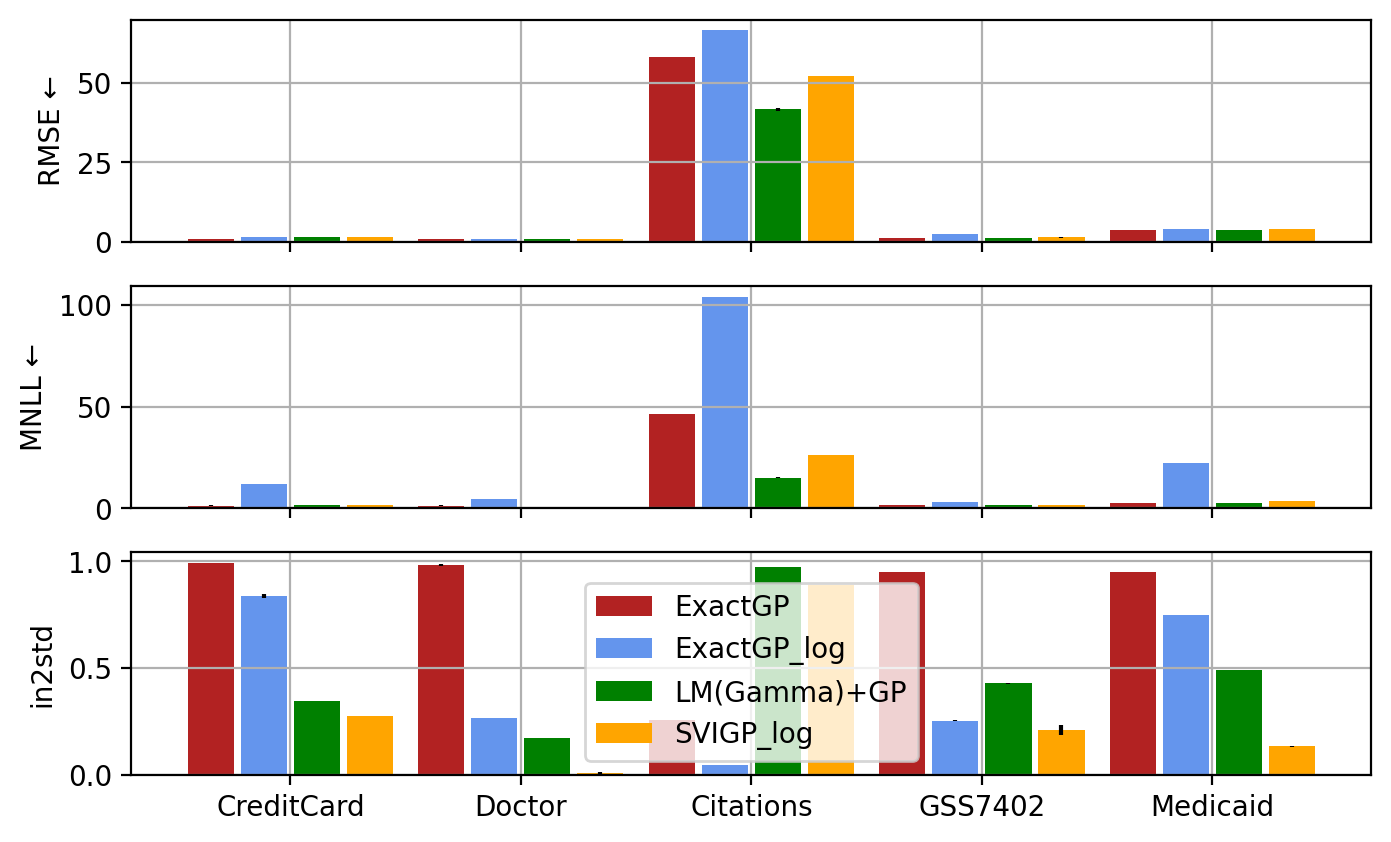

In [63]:
# plot the results
w=0.2
c=0.23
x=np.arange(5)

fig, ax = plt.subplots(3, 1, figsize=(8, 5), dpi=200, sharex=True)

ax[0].bar(x-1.5*c, ExactGP_rmse_mean, width=w, yerr=2*ExactGP_rmse_std, color="firebrick", label="ExactGP")
ax[0].bar(x-0.5*c, ExactGP_log_rmse_mean, width=w, yerr=2*ExactGP_log_rmse_std, color="cornflowerblue", label="ExactGP_log")
ax[0].bar(x+0.5*c, LMGP_rmse_mean, width=w, yerr=2*LMGP_rmse_std, color="green", label="LM(Gamma)+GP")
ax[0].bar(x+1.5*c, SVIGP_log_rmse_mean, width=w, yerr=2*SVIGP_log_rmse_std, color="orange", label="SVIGP_log")
ax[0].grid()
#ax[0].set_ylim(0, 1.05)
ax[0].set_ylabel(u"RMSE \u2190")
#ax[0].legend()

ax[1].bar(x-1.5*c, -ExactGP_mnll_mean, width=w, yerr=2*ExactGP_mnll_std, color="firebrick", label="ExactGP")
ax[1].bar(x-0.5*c, -ExactGP_log_mnll_mean, width=w, yerr=2*ExactGP_log_mnll_std, color="cornflowerblue", label="ExactGP_log")
ax[1].bar(x+0.5*c, -LMGP_mnll_mean, width=w, yerr=2*LMGP_mnll_std, color="green", label="LM(Gamma)+GP")
ax[1].bar(x+1.5*c, -SVIGP_log_mnll_mean, width=w, yerr=2*SVIGP_log_mnll_std, color="orange", label="SVIGP_log")
ax[1].grid()
ax[1].set_ylabel(u"MNLL \u2190")

ax[2].bar(x-1.5*c, ExactGP_in2std_mean, width=w, yerr=2*ExactGP_in2std_std, color="firebrick", label="ExactGP")
ax[2].bar(x-0.5*c, ExactGP_log_in2std_mean, width=w, yerr=2*ExactGP_log_in2std_std, color="cornflowerblue", label="ExactGP_log")
ax[2].bar(x+0.5*c, LMGP_in2std_mean, width=w, yerr=2*LMGP_in2std_std, color="green", label="LM(Gamma)+GP")
ax[2].bar(x+1.5*c, SVIGP_log_in2std_mean, width=w, yerr=2*SVIGP_log_in2std_std, color="orange", label="SVIGP_log")
ax[2].grid()
ax[2].set_ylabel(u"in2std")
ax[2].legend()

ax[2].set_xticks(x)
ax[2].set_xticklabels(["CreditCard", "Doctor", "Citations", "GSS7402", "Medicaid"])

plt.show();

### make a table

the table should have the 5 datasets on the y axis and the 4 methods x 3 metrics on the x-axis

In [75]:
all_results_df = pd.DataFrame(np.stack([ExactGP_rmse_mean, -ExactGP_mnll_mean, ExactGP_in2std_mean, 
                                 ExactGP_log_rmse_mean, -ExactGP_log_mnll_mean, ExactGP_log_in2std_mean, 
                                 LMGP_rmse_mean, -LMGP_mnll_mean, LMGP_in2std_mean, 
                                 SVIGP_log_rmse_mean, -SVIGP_log_mnll_mean, SVIGP_log_in2std_mean]).T)

print(np.shape(all_results_df))
all_results_df.round(3)

(5, 12)


0       1      2       3        4      5       6       7      8   \
0   0.963   1.265  0.991   1.521   11.818  0.837   1.301   1.490  0.344   
1   0.851   1.247  0.982   0.910    4.618  0.265   0.780   0.704  0.169   
2  57.996  46.393  0.256  66.491  104.156  0.047  41.556  15.038  0.972   
3   1.255   1.628  0.949   2.249    2.921  0.253   1.262   1.633  0.428   
4   3.662   2.665  0.948   4.120   22.337  0.748   3.590   2.580  0.489   

       9       10     11  
0   1.304   1.576  0.275  
1   0.811   0.724  0.008  
2  51.950  26.337  0.888  
3   1.312   1.656  0.207  
4   3.831   3.367  0.132

In [76]:
all_results_df.round(3).to_latex()

<ipython-input-76-08f174b53bf5>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  all_results_df.round(3).to_latex()


'\\begin{tabular}{lrrrrrrrrrrrr}\n\\toprule\n{} &      0  &      1  &     2  &      3  &       4  &     5  &      6  &      7  &     8  &      9  &      10 &     11 \\\\\n\\midrule\n0 &   0.963 &   1.265 &  0.991 &   1.521 &   11.818 &  0.837 &   1.301 &   1.490 &  0.344 &   1.304 &   1.576 &  0.275 \\\\\n1 &   0.851 &   1.247 &  0.982 &   0.910 &    4.618 &  0.265 &   0.780 &   0.704 &  0.169 &   0.811 &   0.724 &  0.008 \\\\\n2 &  57.996 &  46.393 &  0.256 &  66.491 &  104.156 &  0.047 &  41.556 &  15.038 &  0.972 &  51.950 &  26.337 &  0.888 \\\\\n3 &   1.255 &   1.628 &  0.949 &   2.249 &    2.921 &  0.253 &   1.262 &   1.633 &  0.428 &   1.312 &   1.656 &  0.207 \\\\\n4 &   3.662 &   2.665 &  0.948 &   4.120 &   22.337 &  0.748 &   3.590 &   2.580 &  0.489 &   3.831 &   3.367 &  0.132 \\\\\n\\bottomrule\n\\end{tabular}\n'